# Método de Simulación

### Grupo 8

- Javier Darna Sequeiros
- Tingyun Wei
- Zihao Hong

*Máster Universitario en Inteligencia Artificial*

In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.integrate import quad
import pandas as pd
from IPython.display import Image

import zignor

import random
from scipy import stats
from scipy.stats import poisson, norm, chi2, expon, uniform
from enum import Enum

import logging

### 1. Generación de números y variables aleatorias
Describir el algoritmo de Ziggurat para	distribuciones con función de densidad decreciente y compararlo	con	otros métodos para la generación de	valores	de la normal

El **algoritmo de Ziggurat** es un método para generar valores aleatorios a partir de una función de densidad monótona decreciente, como la de la distribución exponencial. Sin embargo también se puede aplicar a distribuciones unimodales simétricas, como la distribución normal, generando un valor para la mitad decreciente de la función y  eligiendo aleatoriamente su signo.  

Su nombre proviene de unos templos construidos en la antigua Mesopotamia. Durante el algoritmo, se genera un conjunto de rectángulos "*apilados*" que recordaron a su autor a esta estructura.

<img src="docs/images/ziggurat.png" width="300" height="300">

Este algoritmo está basado el método de rechazo:  

> Primero, generamos puntos aleatorios dentro del rectángulo azul siguiendo una distribución uniforme y luego descartamos  todos los puntos que han quedado por encima de la curva de la distribución, es decir aquellos puntos ($x_{n}$, $y_{n}$) tales que $y_{n}$ > $f(x)$, siendo $f(x)$ la función de distribución de la que queremos generar valores. Posteriormente tomamos la coordenada *x* de cada uno de los puntos restantes, obteniendo así los números.  

La eficiencia de este método suele ser baja porque muchos puntos generados acaban siendo descartados.

<img src="docs/images/1.png" width="300" height="300">

Si pudiéramos modificar el área de generación de puntos de forma que sea lo más parecida posible, y esta es la idea básica del algoritmo de Ziggurat. Específicamente, el algoritmo de Ziggurat funciona de la siguiente manera:

> Dada una función de densidad de probabilidad decreciente $f(x)$, definida para todo $x ≥ 0$, definimos la base del Ziggurat como el conjunto de puntos dentro de la distribución.  

> En primer lugar, dividimos el área debajo de la curva en $n-1$ rectángulos y una cola. Siendo $z_k (k=0,1,...,n-1)$ una sucesión creciente tal que $z_0=0$, formamos el rectángulo $m=1,2,…,n-1$ tomando como esquina superior izquierda el punto $(0,f(z_(m-1) ))$ y como esquina inferior derecha el punto $(z_m,f(z_m ))$, y finalmente definimos la cola como los puntos bajo la curva con ordenada inferior a $f(z_{n-1})$. Los $z_k$ se eligen de forma que las n regiones tengan la misma área. Para generar números elegimos uniformemente una de las regiones y aplicamos el método del rechazo en esa región.  

> En la figura 2, se toma $n=8$, pero en la práctica n puede alcanzar 64, 128 o 256. Llamamos a la parte que se superpone al rectángulo superior en la dirección de la longitud región central del rectángulo actual. El rectángulo superior no tiene región central. 

<img src="docs/images/2.png" width="300" height="300">

**Inicialización**

Para un número especificado n de secciones, podemos resolver numéricamente una ecuación trascendente para encontrar $z_(n-1)$, el punto donde la cola infinita se encuentra con la última sección rectangular. Una vez conocemos $z_n$, podemos calcular el área común de las secciones y los otros puntos $z_k$.  También es posible dividir los rectángulos en dos porciones horizontalmente: la porción (generalmente más grande) de $0$ a $z_(k-1)$ que está completamente contenida dentro de la distribución deseada y llamamos porción central del Ziggurat, y la porción (pequeña) de $z_(k-1)$ a $z_k$, que está solo parcialmente contenida. De esta manera, se puede calcular $σ_k=z_(k-1)/z_k$, que es la fracción de las longitudes de las dos capas de rectángulos adyacentes en dirección horizontal. El borde derecho de la porción central es la línea de puntos en nuestra figura. El rectángulo superior no tiene región central y $σ_1=0$.

El cálculo de los $z_k$ y $σ$ solo necesita realizarse una vez en la inicialización.

**Algoritmo**

Una vez realizada la inicialización, los números aleatorios se pueden generar rápidamente. Calculamos un entero aleatorio $j$, entre $1$ y $n$, con distribución uniforme para elegir una región y un número real aleatorio $u$, distribuido uniformemente entre $−1$ y $1$. Luego comprobamos para ver si $u<σ_j$, es decir si $u$ cae en la porción central de la sección $j$. Si es así, entonces sabemos que $u*z_j$ es la coordenada $x$ de un punto debajo de la función de densidad de probabilidad y este valor se puede devolver como una muestra de la distribución. El pseudocódigo resultante sería el siguiente:

 j = randint(1,n);
  	u = 2*rand()-1;
  	if u < sigma[j]
     		r = u*z[j];
  	end

En el pseudo código anterior, la condición $u < sigma[j]$ se considera verdadera en la mayoría de los casos, y en caso contrario habría que realizar operaciones adicionales. Específicamente, hay tres casos posibles en los que la condición no se cumple: 

> 1. $j=1$, ya que el rectángulo superior no tiene porción central;  
2. $2≤j≤(n-1)$ y $u*z_j$ cae fuera de la porción central (es decir, en el pequeño rectángulo que contiene la curva en el lado derecho);   
3. $j=n$, $u*z_j$ cae en la cola fuera de la porción central inferior. 

En estos tres casos, es necesario realizar operaciones adicionales basadas en el **algoritmo de Box-Muller** utilizando los números aleatorios distribuidos uniformemente que se han generado para generar un número aleatorio según la distribución. Es fácil ver que cuanto mayor sea $n$, menos probable será la ocurrencia de estos tres casos que requieran operaciones adicionales. Según los datos proporcionados en el libro *Numerical Computing with MATLAB*, cuando $n=128$, la probabilidad de requerir operaciones adicionales es inferior al 3%, por lo que esta operación adicional tiene poco efecto sobre la eficiencia general del algoritmo de Ziggurat.

#### Comparación con otros métodos:

**Método de rechazo**: La idea es simple y fácil de implementar, pero puede ser muy ineficiente por dos motivos:
1. Se rechaza una gran proporción de muestras.  
2. Se debe evaluar f(x) para cada punto candidato, lo cual es computacionalmente costoso para muchas funciones de distribución de probabilidad.

**Método de inversión**: Es más complejo, usando directamente la función inversa de la función de distribución acumulativa (FDA) para generar números aleatorios. Además el cálculo implica una función de error más compleja que puede ser no primaria.

**Box-Muller**: Ha sido un algoritmo muy utilizado para generar números aleatorios durante mucho tiempo. El algoritmo Box-Muller se caracteriza por una alta eficiencia y un proceso de cálculo relativamente simple (solo se utilizan funciones elementales), que requieren al menos un logaritmo y un cálculo de raíz cuadrada para los valores generados.

**El algoritmo de Ziggurat**: Es muy eficiente y utilizado por muchos lenguajes de programación modernos. El algoritmo de Ziggurat es en realidad una versión mejorada del método de rechazo. Solo requiere generar aleatoriamente un entero y un real, seguido por una comparación, una operación de multiplicación y una búsqueda en una tabla para obtener un número aleatorio que obedezca a la distribución normal. En todo el proceso, no hay operaciones complicadas, como raíces cuadradas, logaritmos o funciones trigonométricas, al menos en la mayoría de los casos. Sin embargo, dado que el algoritmo de Ziggurat es más complejo de implementar, es mejor usarlo cuando se requieren grandes cantidades de números aleatorios.

#### Creación de la tabla la distribución normal estándar

Utilizando el algoritmo	de Ziggurat obtener	una	aproximación de	la tabla de	la tabla de	la distribución normal estándar.	

Para poder entender de dónde provienen los valores de la tabla, es importante saber acerca de la función de densidad de probabilidad (FDP). Se utiliza esta FDP para especificar la probabilidad de que una variable aleatoria caiga dentro de un rango particular de valores, en lugar de tomar cualquier valor. Esta probabilidad viene dada por la integral de la FDP de la variable sobre el rango. La siguiente ecuación es la función de densidad de probabilidad para una distribución normal $N(μ,σ^2)$.
 $f(x|\mu,\sigma^2) = \frac{1}{ \sqrt{(2 \pi \sigma^2}} \, e^{-\frac{(x-\mu^2)}{2 \sigma^2}}$ 
 
 La cual podemos simplificar tomando la distribución normal estándar de media (μ) 0 y desviación estándar (σ) 1.
 $f(x) = \frac{1}{ \sqrt{(2 \pi}} \, e^{-\frac{(x^2)}{2}}$

In [2]:
def pdf_standard_normal_distribution(x):
    return (1 / (np.sqrt(2 * np.pi))) * np.exp((x ** 2) / -2)

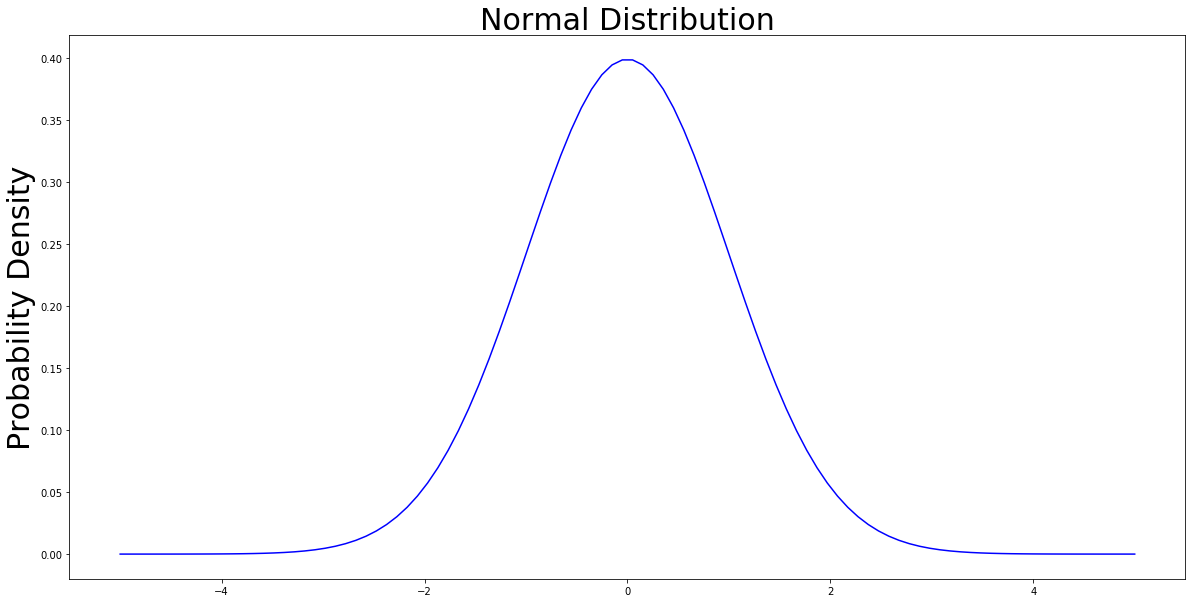

In [3]:
DOMAIN = 5
N = 100
TITLE_SIZE = 30
FIGURE_SIZE = (20, 10)

domain = np.linspace(-DOMAIN, DOMAIN, N) # return a domain from [0, 1] in 100 parts

fig, ax = plt.subplots(figsize=(FIGURE_SIZE[0], FIGURE_SIZE[1]));

# config
ax.set_title('Normal Distribution', size = TITLE_SIZE);
ax.set_ylabel('Probability Density', size = TITLE_SIZE);

ax.plot(domain, list( # domain is the x axis and the rest y axis
    map(
        lambda x: pdf_standard_normal_distribution(x), 
        domain
    )
), color = 'b')

plt.show()

La tabla de la normal estándar contiene los datos de la probabilidad de un evento dentro del intervalo $[0, z]$, es decir, el área bajo la curva normal estándar entre $0$ y $z$. El gráfico anterior no muestra la probabilidad de eventos, sino su densidad de probabilidad. Para encontrar el área, necesita integrarse. La integración del FDP proporciona una función de distribución acumulativa (FDA), que asigna valores a su rango de percentil en una distribución. Los valores de la tabla se calculan utilizando la función de distribución acumulativa de una distribución normal estándar con media 0 y desviación estándar 1. Esto se puede denotar con la siguiente ecuación.  
  
$\int_{0}^{z}{\frac{1}{2\pi}}e^{\frac{-x^2}{2}}dx$

En esta práctica vamos a utilizar el algoritmo de Ziggurat para crear la tabla. El primer paso es generar $n$ números aleatorios según la distribución normal utilizando el algoritmo. En nuestro caso, generamos 10000, cambiamos su signo aleatoriamente y los truncamos a 2 decimales. Después, establecemos un contador para calcular la acumulación de cada valor del número aleatorio y lo normalizamos. De esta manera, obtenemos la frecuencia de cada valor, la cual usamos como aproximación del valor correspondiente de la función de densidad. 

Con el objetivo de obtener la probabilidad acumulada dentro de un rango desde 0 hasta un valor $z$ del numero aleatorio, se suman todas las frecuencias calculadas de los valores de los números menores que $z$. En esta práctica, se han generado las 10 primeras filas de la tabla, es decir, se han calculado las probabilidades acumuladas de los valores $z$ desde 0 hasta 0.99. No se muestran las probabilidades para los $z$ negativos ya que $F(-z)=1-F(z)$.

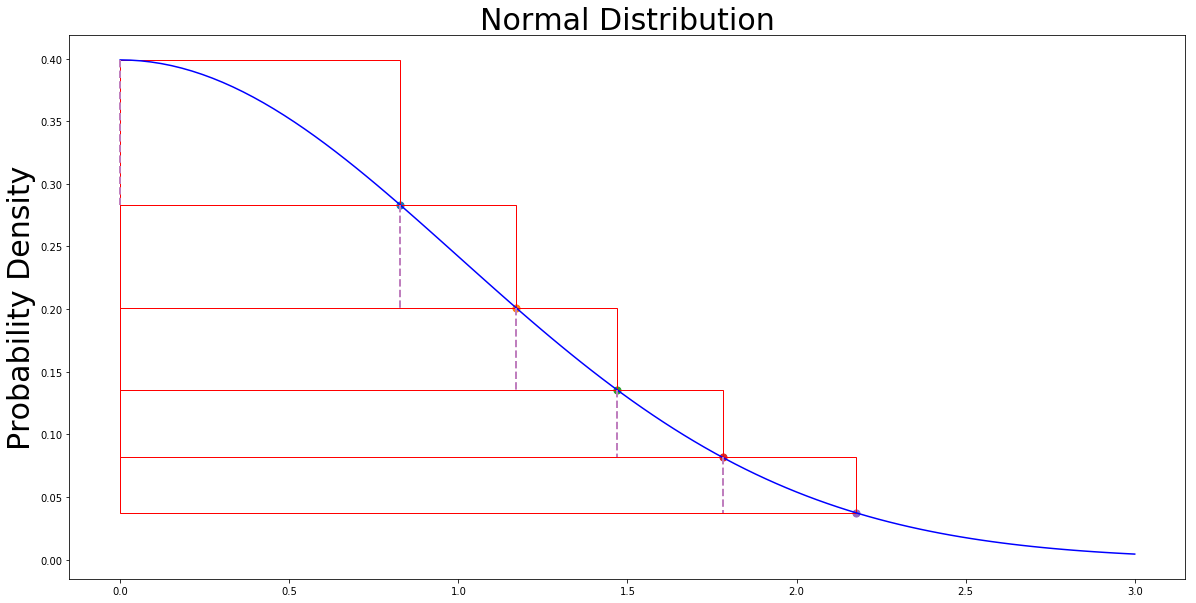

In [4]:
DOMAIN = 3
N = 100
POINT_SIZE = 50
TITLE_SIZE = 30
FIGURE_SIZE = (20, 10)

domain = np.linspace(0, DOMAIN, N) # return a domain from [0, 1] in 100 parts

divisions = [0, 0.8288, 1.1713, 1.4696, 1.7819, 2.1761]

fig, ax = plt.subplots(figsize=(FIGURE_SIZE[0], FIGURE_SIZE[1]));

# config
ax.set_title('Normal Distribution', size = TITLE_SIZE);
ax.set_ylabel('Probability Density', size = TITLE_SIZE);

ax.plot(domain, list( # domain is the x axis and the rest y axis
    map(
        lambda x: pdf_standard_normal_distribution(x), 
        domain
    )
), color = 'b')
currentAxis = plt.gca()

for i in range(1, len(divisions)):
    y = pdf_standard_normal_distribution(divisions[i]) # calculate its y axis value
    y_prev = pdf_standard_normal_distribution(divisions[i - 1]) # calculate divisions i - 1 y axis value
    
    plt.scatter(divisions[i], y, s = POINT_SIZE) # draw point s is size
    rect = patches.Rectangle((0, y), divisions[i], y_prev - y, linewidth = 1, edgecolor = 'r', fill = None) # draw rectangle
    plt.plot([divisions[i - 1], divisions[i - 1]], [y_prev, y], color = '#BF7EBE', linewidth = 2, linestyle = 'dashed') # draw lines
    
    currentAxis.add_patch(rect) # add rectangle

plt.show()
plt.close()

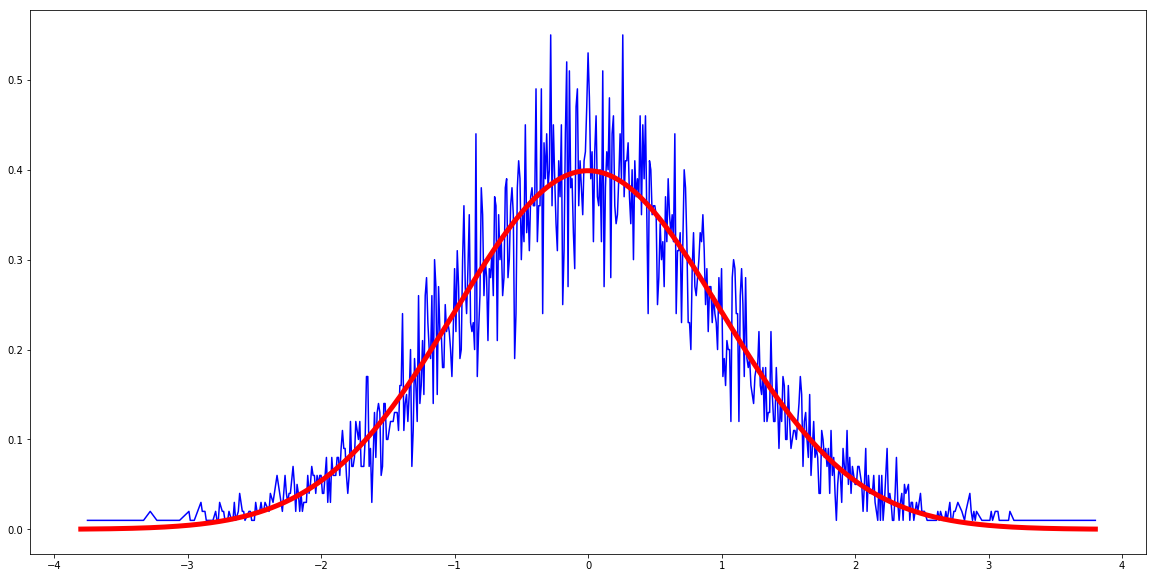

In [6]:
POINT_SIZE = 50
N = 10000

random_numbers = zignor.randn(N)

counter = {}
for rand in random_numbers:
    round_rand_number = np.round(rand, 2) # round the number to 2 decimals
    counter[round_rand_number] = counter.get(round_rand_number, 0) + 1
    
x_axis = sorted(list(counter.keys()))
y_axis = list(map(lambda x : counter[x] / N * 100, x_axis))

domain = np.linspace(-max(x_axis), max(x_axis), N)

fig, ax = plt.subplots(figsize = (FIGURE_SIZE[0], FIGURE_SIZE[1]));

ax.plot(x_axis, y_axis, color = 'b')

ax.plot(domain, list( # domain is the x axis and the rest y axis
    map(
        lambda x: pdf_standard_normal_distribution(x), 
        domain
    )
), color = 'r', linewidth = 5)

plt.show()

In [7]:
standard_normal_table = pd.DataFrame(
    data =[],
    index = np.round(np.arange(0, 1, .1), 2),
    columns = np.round(np.arange(0.00, .1, .01), 2)
)

for index in standard_normal_table.index:
    for column in standard_normal_table.columns:
        z = np.round(index+column, 2)
        value = 0
        for k in np.round(np.arange(min( random_numbers ), z, .01), 2):
            if counter.get( k ) is not None:
                value = value + counter.get(k)
        standard_normal_table.loc[index, column] = value / N
        
standard_normal_table.index = standard_normal_table.index.astype(str)
standard_normal_table.columns = [str(column).ljust(4, '0') for column in standard_normal_table.columns]

standard_normal_table

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09
0.0,0.4944,0.4997,0.5045,0.5084,0.5126,0.5158,0.52,0.5246,0.5283,0.5319
0.1,0.5359,0.5391,0.5442,0.5469,0.5507,0.5549,0.5589,0.5637,0.5665,0.5709
0.2,0.5755,0.5791,0.5825,0.586,0.5899,0.5943,0.5982,0.6037,0.6074,0.6115
0.3,0.6156,0.6199,0.6236,0.627,0.631,0.634,0.6381,0.6418,0.6457,0.6494
0.4,0.654,0.6575,0.662,0.6659,0.6705,0.674,0.6764,0.6805,0.6845,0.688
0.5,0.6916,0.6952,0.6987,0.7012,0.704,0.7074,0.7104,0.7136,0.7163,0.72
0.6,0.7232,0.7271,0.7306,0.7339,0.7374,0.7406,0.745,0.7474,0.7505,0.7536
0.7,0.7569,0.7592,0.7624,0.7664,0.7702,0.7734,0.7757,0.778,0.78,0.7829
0.8,0.7862,0.7889,0.7915,0.7943,0.7973,0.8006,0.8038,0.8073,0.8104,0.8129
0.9,0.8158,0.818,0.8207,0.8234,0.8257,0.8283,0.8307,0.833,0.835,0.8378


### 2. Simulación de sucesos discretos.
Llegan petroleros para descargar en el muelle según un proceso de Poisson no homogéneo con la siguiente tasa:

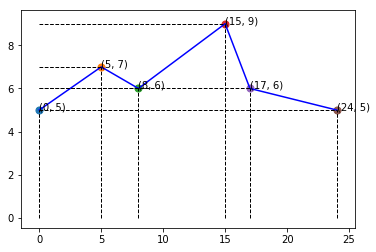

In [8]:
POINT_SIZE = 50

values = [(0, 5), (5, 7), (8, 6), (15, 9), (17, 6), (24, 5)]
x_axis = list(map(lambda x : x[0], values))
y_axis = list(map(lambda y : y[1], values))

fig, ax = plt.subplots()
plt.plot(x_axis, y_axis, color = 'b')
for i in values:
    plt.scatter(i[0], i[1], s = POINT_SIZE) # draw point s is size
    ax.annotate("(" + str(i[0]) + ", " + str(i[1]) + ")", (i[0], i[1])) # add labels
    plt.plot([i[0], i[0]], [0, i[1]], color = 'black', linewidth = 1, linestyle = 'dashed') # draw vertical lines
    plt.plot([0, i[0]], [i[1], i[1]], color = 'black', linewidth = 1, linestyle = 'dashed') # draw horizontal lines
plt.show()


El petrolero llega hasta la entrada del puerto, y espera a que un remolcador 
esté disponible y lo lleve hasta el muelle. Se disponen en el puerto de 10 
remolcadores.

Los remolcadores también realizan la labor de llevar cada petrolero hasta la 
entrada del puerto tras haber descargado. En el fichero “desplazamientos.txt”
se dispone de una muestra de las duraciones de los desplazamientos del
remolcador con el petrolero. Contrástese si la distribución de dichos tiempos es
normal (truncada), uniforme o exponencial y estímense los parámetros de la
distribución correspondiente.

In [9]:
# input data
file= open('docs/data/E8.desplazamientos.txt')
data_desplazamiento= np.loadtxt(file, unpack='true')
file.close()

In [10]:
#  scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two_sided', mode='approx', **kwds)
# rvs --> test data; cdf --> distribution type，'norm'，'expon'，'rayleigh'，'gamma'；args=() distribution parametric
# N: if vs is string，N is the size of sample
# if p-value is bigger than the level of significance（5％），accept H0，The sample data can be considered to be from a given distribution F(x)
loc, scale = norm.fit(data_desplazamiento)
n = norm(loc=loc, scale=scale)
stats.kstest(data_desplazamiento, n.cdf)

KstestResult(statistic=0.01035501786004428, pvalue=0.6571586727422323)

Dado que el tiempo de desplazamiento es una variable aleatoria continua, podemos usar la prueba de Kolmogórov-Smirnov (prueba K-S) para contrastar su tipo de distribucion.

$D_{n}^{+}=\max(F_{n}(x)-F(x))$

Según el teorema de Glivenko-Cantelli, si la muestra proviene de la distribución F (x), entonces Dn converge a 0 casi seguramente en el límite cuando n va al infinito. Y el p-value informa si los números difieren significativamente.

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html

In [11]:
loc, scale = uniform.fit(data_desplazamiento)
u = uniform(loc=loc, scale=scale)
stats.kstest(data_desplazamiento, u.cdf)

KstestResult(statistic=0.2177462278558, pvalue=2.43873358745901e-206)

In [12]:
loc, scale = expon.fit(data_desplazamiento)
ex = expon(loc=loc, scale=scale)
stats.kstest(data_desplazamiento, ex.cdf)

KstestResult(statistic=0.3581258415266688, pvalue=0.0)

In [13]:
# method of moments --> estimate parametrics of a normal distribution
mu = np.mean(data_desplazamiento)
sigma = np.std(data_desplazamiento)
print("Mu: " + str(mu))
print("Sigma: " + str(sigma))

Mu: 10.007615178514001
Sigma: 3.0373964893054275


De acuerdo con los resultados de los test de Kolmogorov–Smirnov, para la distribución normal, el valor estadística D es muy pequeño y el p-value es más de 5%. Entonces la distribución de los tiempos del desplazamiento es normal (truncada).

In [14]:
stats.anderson(data_desplazamiento, dist='expon')

AndersonResult(statistic=1106.7655637247299, critical_values=array([0.922, 1.078, 1.341, 1.606, 1.957]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Cuando el remolcador va de vacío (sin remolcar) la distribución es también 
normal pero con media de 2 minutos y desviación típica 1. 

Existe un número limitado de 20 muelles donde pueden atracar los 
petroleros. El tiempo de descarga de cada petrolero tiene una distribución 
chi cuadrado con 2 grados de libertad, expresada en horas. 

El remolcador da prioridad a los petroleros que llegan sobre los que 
abandonan el puerto.
A. Simule el comportamiento del puerto para estimar el tiempo medio 
que tardan en atracar los barcos, el tiempo máximo en atracar, el 
número medio de barcos atracados en el puerto y el número medio y 
máximo de barcos esperando a atracar.
B. Analice la posibilidad de disponer de 3 nuevos remolcadores y 
realizar obras para disponer de 5 nuevos muelles ¿cuál de las dos 
opciones es mejor?

Una distribución de Poisson da la probabilidad de varios eventos en un intervalo generado por un proceso de Poisson. La distribución de Poisson se define mediante el parámetro de velocidad, λ, que es el número esperado de eventos en el intervalo (eventos / intervalo * duración del intervalo) y el número más alto de probabilidad de eventos. También podemos usar la Distribución de Poisson para encontrar el tiempo de espera entre eventos. Incluso si llegamos a un tiempo aleatorio, el tiempo de espera promedio siempre será el tiempo promedio entre eventos.


In [15]:
# Params

LOG_FILE = 'ports.log'
# Num of tugs available
MAXTUGS = 10
# Num of wharves available
MAXWHARVES = 20
# Max time
T = 7 * 24 * 60 # 7 days
TUG_MU_EMPTY = 2
TUG_SIGMA_EMPTY = 1
TUG_MU_FULL = mu
TUG_SIGMA_FULL = sigma
WHARVE_FREEDOM_DEGREE = 2

In [16]:
# Transforma el tiempo de simulacion en un formato interpretablr
def minutesToTime(minutes):
    hours = int(minutes / 60)
    seconds = int( (minutes - int(minutes)) * 60)
    minutes = int(minutes - hours * 60)
    days = int(hours/24)
    hours = hours - days*24
    return str(days) + "d " + str(hours) + "h " + str(minutes) + "min " + str(seconds) + "s"

In [17]:
# Returns the poisson proccess rate
# t: time in minutes along a month
# As t could be any minute in a month, we need to get the t in minutes in the day

def getPoissonRate(t):
    lambd = 0
    h_in_day = (t / 60.0) % 24.0
    if h_in_day >= 0.0 and h_in_day < 5.0:
        lambd = 2.0 / 5.0 * h_in_day + 5.0
    elif h_in_day >= 5.0 and h_in_day < 8.0:
        lambd = -1.0 / 3.0 * h_in_day + 26.0 / 3.0
    elif h_in_day >= 8.0 and h_in_day < 15.0:
        lambd = 3.0 / 7.0 * h_in_day + 18.0 / 7.0
    elif h_in_day >= 15.0 and h_in_day < 17.0:
        lambd = -3.0 / 2.0 * h_in_day + 63.0/2.0
    elif h_in_day >= 17.0 and h_in_day < 24.0:
        lambd = -1.0 / 7.0 * h_in_day + 59.0 / 7.0
    else: 
        logging.error("lambda out of index")
    return lambd;

# used for poisson distribution and exponential distribution
    

In [18]:
# Enumeracion que contiene los tipos de eventos posibles
class Events(Enum):  
    TANKER_ARRIVAL = 0 # Indica la entrada de un barco al puerto.
    TUG_TO_PORT_EMPTY = 1 # Un remolcador llega a la entrada sin barco
    TUG_TO_PORT_FULL = 2 # Un remolcador llega a la entrada con un barco
    TUG_TO_WHARVE_EMPTY = 3 # Un remolcador llega a los muelles sin barco
    TUG_TO_WHARVE_FULL = 4 # Un remolcador llega a los muelles con un barco
    TANKER_UNLOADED = 5 # Un barco ha terminado de descargar

# Clase para guardar una lista de eventos. Cada elemento es una tupla con
# el tipo de evento, el tiempo en el que ocurre, y un identificador de
# un remolcador o un barco segun el tipo de evento.
class ListEvents():
    L = []
    
    def __init__( self ):
        self.L = []
    
    # Para ordenar la lista con la funcion sorted(), devuelve el momento del evento
    def comparator(self, value):
        return value[1]
    
    # Devuelve el tamano de la lista
    def size(self):
        return len(self.L)
    
    # Anade un evento a partir del momento y el tipo. Ademas ordena la
    # lista para que los eventos queden en orden cronologico.
    def push(self, event_type, time, ID = None):
        self.L.append((event_type, time, ID))
        self.L = sorted(self.L, key = self.comparator)
    
    # Saca y devuelve el primer elemento de la lista.
    def pop(self):
        event, event_time, ID = self.L[0]
        self.L = self.L[1:]
        return event, event_time, ID

In [19]:
# Clase para guardar los petroleros que han pasado por el sistema.
# Contiene, para cada uno, un identificador y los tiempos de los
# eventos relevantes.
class ListTankers:
    def __init__(self):
        self.L = []
        
    # Anade un nuevo petrolero a la lista, guardando ademas su
    # tiempo de llegada.
    def add(self, time_event):
        tank = {
            "id": len(self.L),
            "arrival_time": time_event,
            "entrance_pick_by_tug_time" : -1,
            "wharve_arrival_time" : -1,
            "wharve_unload_done_time" : -1,
            "wharve_pick_by_tug_time" : -1,
            "exit_time" : -1
        }
        self.L.append(tank)
        return self.L[-1]
    
    # Devuelve un petrolero segun su identificador.
    def get(self, tank_id):
        return self.L[tank_id]
    
    # Convierte la lista de petroleros en una cadena legible.
    def toString(self):
        return list(
            map(
                lambda tanker: "TANKER " + str( tanker["id"] ),
                self.L
            )
        )

In [20]:
# Clase para guardar la infomacion de los remolcadores. Para cada uno
# se guarda un identificador, su estado y el identificador del
# petrolero que este remolcando (o None si va de vacio)
class ListTugs():
    L = []
    
    def __init__(self, max_tugs):
        self.max_tugs = max_tugs
        self.L = list(
            map(
                lambda i : {
                    "id": i,
                    "status": "at_port",
                    "carry": None # if carrying tanker
                },
                list(range(max_tugs))
            )
        ) 
    
    # Devuelve los remolcadores cuyo estado pertenezca a una lista
    # pasada por parametro.
    def getTugsWithStatus(self, status): # status es list de strings
        return list(
            filter(
                lambda tug: tug["status"] in status,
                self.L
            )
        )
    
    #Devuelve un remolcador segun su indice.
    def get(self, index):
        return self.L[index]
    
    # Convierte la lista de remolcadores en una cadena legible.
    def toString(self):
        return str(list(
            map(
                lambda tug: str( tug["status"] ) + ". Carrying " + str( tug["carry"] ),
                self.L
            )
        ))
    

In [21]:
# Clase para guardar la informacion de los muelles. Para cada uno
# guardamos un identificador y el petrolero que contengan (None si
# estan libres)
class ListWharves():
    L = []
    
    def __init__(self, max_wharves):
        self.max_wharves = max_wharves
        self.L = list(
            map(
                lambda i : {
                    "id": i,
                    "unloading": None # if unloading tanker
                },
                list(range(max_wharves))
            )
        ) 
    
    #Devuelve la lista de muelles vacios.
    def getEmpty(self):
        return list(
            filter(
                lambda wharve: wharve["unloading"] is None,
                self.L
            )
        )
    
    # Convierte la lista de muelles en una cadena legible.
    def toString(self):
        return str(list(
            map(
                lambda wharve: wharve["unloading"],
                self.L
            )
        ))
    
    #Devuelve un muelle segun el petrolero que contenga
    def getByUnloading(self, unloading):
        for i in self.L:
            if i["unloading"] == unloading:
                return i
        return None

In [38]:
# Clase para las simulaciones del ejercicio 2
class Simulation:
    def __init__(
        self, 
        tug_mu_empty = TUG_MU_EMPTY,
        tug_sigma_empty = TUG_SIGMA_EMPTY, 
        tug_mu_full = TUG_MU_FULL, 
        tug_sigma_full = TUG_SIGMA_FULL,
        wharve_freedom_degree = WHARVE_FREEDOM_DEGREE,
        max_tugs = MAXTUGS, 
        max_wharves = MAXWHARVES,
        max_time = T
    ):
        logging.info('{:>40}'.format("") + "  Simulation parameters initialization ...")
        
        self.tug_mu_empty = tug_mu_empty # Parametro mu para los desplazamientos de los remolcadores cuando van de vacio.
        self.tug_sigma_empty = tug_sigma_empty # Parametro sigma para los desplazamientos de los remolcadores cuando van de vacio.
        self.tug_mu_full = tug_mu_full # Parametro mu para los desplazamientos de los remolcadores cuando llevan un petrolero.
        self.tug_sigma_full = tug_sigma_full # Parametro sigma para los desplazamientos de los remolcadores cuando llevan un petrolero.
        self.wharve_freedom_degree = wharve_freedom_degree # Grados de libertad para el tiempo de descarga de los petroleros
        
        self.list_events = ListEvents() #Lista de eventos
        
        self.list_tankers = ListTankers() #Lista de petroleros
        self.list_tugs = ListTugs(max_tugs) #Lista de remolcadores
        self.list_wharves = ListWharves(max_wharves) #Lista de muelles
        
        self.tankers_waiting_entrance = [] #Cola de la entrada del puerta
        self.tankers_finished_unloading = [] #Cola de petroleros que han terminado de descargar
        self.tankers_exit = [] #Petroleros que han abandonado el sistema
        
        self.time = 0.0 # Reloj de la simulacion
        self.max_time = max_time # Tiempo maximo de simulacion
        
        self.max_tugs = max_tugs # Numero de remolcadores
        self.max_wharves = max_wharves # Numero de muelles
        
        # statistics
        self.mean_time_to_dock = 0.0 # Tiempo medio que tarda un barco para llegar al muelle
        self.max_time_to_dock = 0.0 # Tiempo maximo que tarda un barco para llegar al muelle
        self.mean_tankers_docked = 0.0 # Numero medio de barcos en los muelles
        self.mean_tankers_wait_at_entrance = 0.0 # Numero medio de barcos esperando en la entrada
        self.max_tankers_wait_at_entrance = 0 # Numero maximo de barcos esperando en la entrada
        
        logging.info('{:>40}'.format("") + "  Simulation parameters initialized")
        
    # Funcion para empezar la simulacion
    def simulate(self):
        logging.info('{:>40}'.format("") + "  Simulation starting ...")
        
        # Calculamos la llegada del primer barco.
        x = 60 * random.expovariate(getPoissonRate(self.time))
        
        # Si el primer barco llega despues del final de la simulacion,
        # devuelve error
        if x > self.max_time:
            logging.error("No tankers arrived during simulation time. Ending...")
            return -1
        else:
            # Add the first event (the first tank arrival)
            self.list_events.push(Events.TANKER_ARRIVAL, self.time + x)
            # Bucle principal en el que se tratan eventos durante el
            # tiempo de simulacion.
            while self.list_events.size() > 0:
                # Tomamos el proximo evento
                event, time_event, ID =  self.list_events.pop()
                
                #Actualizamos las estadisticas
                self.mean_tankers_docked += ( self.max_wharves - len( self.list_wharves.getEmpty() ) ) * (time_event - self.time)
                self.mean_tankers_wait_at_entrance += len(self.tankers_waiting_entrance) * (time_event - self.time)
                self.max_tankers_wait_at_entrance = max(len( self.tankers_waiting_entrance), self.max_tankers_wait_at_entrance)
                
                self.time = time_event
                
                # Llamamos a diferentes rutinas segun el tipo de evento
                if event == Events.TANKER_ARRIVAL:
                    self.tankerArrival()
                if event == Events.TUG_TO_PORT_EMPTY:
                    self.tugToPortEmpty(ID)
                if event == Events.TUG_TO_PORT_FULL:
                    self.tugToPortFull(ID)
                if event == Events.TUG_TO_WHARVE_EMPTY:
                    self.tugToWharveEmpty(ID)
                if event == Events.TUG_TO_WHARVE_FULL:
                    self.tugToWharveFull(ID)
                if event == Events.TANKER_UNLOADED:
                    self.tankerUnloaded(ID)
                    
                logging.info('{:>40}'.format("Tankers waiting at entrance") + ": " + str(self.tankers_waiting_entrance))
                logging.info('{:>40}'.format("Tankers finished unloading") + ": " + str(self.tankers_finished_unloading))
                logging.info('{:>40}'.format("Tankers to sea") + ": " + str(self.tankers_exit))
                logging.info('{:>40}'.format("Tugs") + ": " + self.list_tugs.toString())
                logging.info('{:>40}'.format("Wharves") + ": " + self.list_wharves.toString())
                
            # Calculamos las estadisticas relacionadas con tiempos
            for i in self.list_tankers.L:
                dock_time = i["wharve_arrival_time"] - i["arrival_time"]
                self.max_time_to_dock = max(self.max_time_to_dock, dock_time)
                self.mean_time_to_dock += dock_time

            self.mean_time_to_dock /= len(self.list_tankers.L)
            self.mean_tankers_docked /= self.time
            self.mean_tankers_wait_at_entrance /= self.time
            
            logging.info("")
            logging.info('{:>40}'.format("mean_time_to_dock") + ": " + str(self.mean_time_to_dock))
            logging.info('{:>40}'.format("max_time_to_dock: ") + ": " + str(self.max_time_to_dock))
            logging.info('{:>40}'.format("mean_tankers_docked") + ": " + str(self.mean_tankers_docked))
            logging.info('{:>40}'.format("mean_tankers_wait_at_entrance") + ": " + str(self.mean_tankers_wait_at_entrance))
            logging.info('{:>40}'.format("max_tankers_wait_at_entrance") + ": " + str(self.max_tankers_wait_at_entrance))
            logging.info("")
            
            # Resultados de la simulacion
            print("Simulation(tugs: " + str(self.max_tugs) + ", wharves: " + str(self.max_wharves) + ")")
            print('{:>40}'.format("mean_time_to_dock") + ": " + str(self.mean_time_to_dock))
            print('{:>40}'.format("max_time_to_dock: ") + ": " + str(self.max_time_to_dock))
            print('{:>40}'.format("mean_tankers_docked") + ": " + str(self.mean_tankers_docked))
            print('{:>40}'.format("mean_tankers_wait_at_entrance") + ": " + str(self.mean_tankers_wait_at_entrance))
            print('{:>40}'.format("max_tankers_wait_at_entrance") + ": " + str(self.max_tankers_wait_at_entrance))
            print("")
                    
            return 0
    
    # Rutina para cuando un petrolero llega al sistema
    def tankerArrival(self):
        # Anadimos el petrolero a la lista
        tanker = self.list_tankers.add(self.time)
        
        logging.info('{:>20}'.format(str(self.time)) + '{:>20}'.format(minutesToTime(self.time)) + ": TANKER " + str(tanker["id"]) + " arrived at port")
        
        # Calculamos la llegada del siguiente petrolero y,
        # si no excede el tiempo maximo, lo anadimos a la lista de
        # eventos
        x = 60 * random.expovariate(getPoissonRate(self.time))
        if self.time + x > self.max_time:
            logging.info('{:>40}'.format("") + "  End of tanker arrivals.")
        else:    
            self.list_events.push(Events.TANKER_ARRIVAL, self.time + x)
        
        # Anadimos el petrolero a la cola
        self.tankers_waiting_entrance.append(tanker["id"])
        
        # Si hay remolcadores en la entrada y hay muelles libres,
        # uno de los remolcadores remolca el primer petrolero de la
        # cola hasta un  muelle.
        if len(self.list_tugs.getTugsWithStatus(["at_port"])) > 0 and len(self.list_wharves.getEmpty()) > 0:
            tug_available = self.list_tugs.getTugsWithStatus(["at_port"])[0]
            tug_available["carry"] = self.tankers_waiting_entrance[0]
            tug_available["status"] = "to_wharve"
            
            tanker_update = self.list_tankers.get(self.tankers_waiting_entrance[0])
            tanker_update["entrance_pick_by_tug_time"] = self.time
            
            # "Reservamos" el muelle para evitar condiciones de
            # carrera.
            wharve = self.list_wharves.getByUnloading(None)
            wharve["unloading"] = self.tankers_waiting_entrance[0]
            
            self.tankers_waiting_entrance = self.tankers_waiting_entrance[1:]
            
            # Anadimos un evento de llegada de remolcador a los
            # muelles con barco
            y = random.normalvariate(self.tug_mu_full, self.tug_sigma_full)
            self.list_events.push(Events.TUG_TO_WHARVE_FULL, self.time + y, tug_available["id"])
    
    # Rutina para cuando un remolcador llega a la entrada de vacio
    def tugToPortEmpty(self, tug_id):
        tug = self.list_tugs.get(tug_id)
        
        logging.info('{:>20}'.format(str(self.time)) + '{:>20}'.format(minutesToTime(self.time)) + ": TUG " +  str(tug_id) + " arrived to port empty")
        
        # Si hay petroleros esperando y hay muelles libres,
        # el remolcador remolca el primer petrolero de la
        # cola hasta un  muelle.
        if len(self.tankers_waiting_entrance) > 0 and len(self.list_wharves.getEmpty()) > 0:
            tanker_id = self.tankers_waiting_entrance[0]
            tug["carry"] = tanker_id
            tug["status"] = "to_wharve"
            
            tanker_update = self.list_tankers.get( tanker_id )
            tanker_update["entrance_pick_by_tug_time"] = self.time
            
            wharve = self.list_wharves.getByUnloading(None)
            wharve["unloading"] = self.tankers_waiting_entrance[0]
            
            self.tankers_waiting_entrance = self.tankers_waiting_entrance[1:]
            
            y = random.normalvariate(self.tug_mu_full, self.tug_sigma_full)
            self.list_events.push(Events.TUG_TO_WHARVE_FULL, self.time + y, tug_id)
        # Si hay petroleros esperando en los muelles, el remolcador
        # parte hacia ahi de vacio.
        elif len(self.tankers_finished_unloading) > 0:
            tug["status"] = "to_wharve"
            
            y = random.normalvariate(self.tug_mu_empty, self.tug_sigma_empty)
            self.list_events.push(Events.TUG_TO_WHARVE_EMPTY, self.time + y, tug_id)
        # Si no hay petroleros esperando, los remolcadores se reparten
        # entre los dos puntos clave del puerto.
        else:
            tugs_at_port = len(self.list_tugs.getTugsWithStatus(["at_port"]))
            tugs_at_wharve = len(self.list_tugs.getTugsWithStatus(["at_wharve"]))
            
            if tugs_at_port <= tugs_at_wharve:
                tug["status"] = "at_port"
            else:
                tug["status"] = "to_wharve" 
                y = random.normalvariate(self.tug_mu_empty, self.tug_sigma_empty)
                self.list_events.push(Events.TUG_TO_WHARVE_EMPTY, self.time + y, tug_id)
    
    # Rutina para cuando un remolcador llega a la entrada con un
    # petrolero.
    def tugToPortFull(self, tug_id):
        # El petrolero sale del sistema.
        tug = self.list_tugs.get(tug_id)
        self.tankers_exit.append(tug["carry"])
        
        tanker_update = self.list_tankers.get(tug["carry"])
        tanker_update["exit_time"] = self.time
        
        logging.info('{:>20}'.format(str(self.time)) + '{:>20}'.format(minutesToTime(self.time)) + ": TANKER " + str(tug["carry"]) + " back to sea")
        
        tug["carry"] = None
        
        # Si hay petroleros esperando y hay muelles libres,
        # el remolcador remolca el primer petrolero de la
        # cola hasta un  muelle.
        if len(self.tankers_waiting_entrance) > 0 and len(self.list_wharves.getEmpty()) > 0:
            tanker_id = self.tankers_waiting_entrance[0]
            tug["carry"] = tanker_id
            tug["status"] = "to_wharve"
            
            tanker_update = self.list_tankers.get( tanker_id )
            tanker_update["entrance_pick_by_tug_time"] = self.time
            
            # "Reservamos" el muelle para evitar condiciones de
            # carrera.
            wharve = self.list_wharves.getByUnloading(None)
            wharve["unloading"] = self.tankers_waiting_entrance[0]
            
            self.tankers_waiting_entrance = self.tankers_waiting_entrance[1:]
            
            y = random.normalvariate(self.tug_mu_full, self.tug_sigma_full)
            self.list_events.push(Events.TUG_TO_WHARVE_FULL, self.time + y, tug_id)
        # Si hay petroleros esperando en los muelles, el remolcador
        # parte hacia ahi de vacio.
        elif len(self.tankers_finished_unloading) > 0:
            tug["status"] = "to_wharve"
            
            y = random.normalvariate(self.tug_mu_empty, self.tug_sigma_empty)
            self.list_events.push(Events.TUG_TO_WHARVE_EMPTY, self.time + y, tug_id)
        # Si no hay petroleros esperando, los remolcadores se reparten
        # entre los dos puntos clave del puerto.
        else:
            tugs_at_port = len(self.list_tugs.getTugsWithStatus(["at_port"]))
            tugs_at_wharve = len(self.list_tugs.getTugsWithStatus(["at_wharve"]))
            
            if tugs_at_port <= tugs_at_wharve:
                tug["status"] = "at_port"
            else:
                tug["status"] = "to_wharve" 
                y = random.normalvariate(self.tug_mu_empty, self.tug_sigma_empty)
                self.list_events.push(Events.TUG_TO_WHARVE_EMPTY, self.time + y, tug_id)
    
    # Rutina para cuando un remolcador llega a la entrada de vacio.
    def tugToWharveEmpty(self, tug_id):
        tug = self.list_tugs.get(tug_id)
        
        logging.info('{:>20}'.format(str(self.time)) + '{:>20}'.format(minutesToTime(self.time)) + ": TUG " +  str(tug_id) + " arrived to wharve empty")
        
        # Si hay petroleros esperando en la entrada, el remolcador
        # parte hacia ahi de vacio para cumplir las prioridades
        if len(self.tankers_waiting_entrance) > 0 and len(self.list_wharves.getEmpty()) > 0:
            tug["status"] = "to_port"
            
            y = random.normalvariate(self.tug_mu_empty, self.tug_sigma_empty)
            self.list_events.push(Events.TUG_TO_PORT_EMPTY, self.time+y, tug_id)
        # Si hay petroleros esperando,
        # el remolcador remolca el primer petrolero de la
        # cola hasta la salida.
        elif len(self.tankers_finished_unloading) > 0:
            tanker_id = self.tankers_finished_unloading[0]
            tug["carry"] = tanker_id
            tug["status"] = "to_port"
            
            tanker_update = self.list_tankers.get( tanker_id )
            tanker_update["wharve_pick_by_tug_time"] = self.time
            
            y = random.normalvariate(self.tug_mu_full, self.tug_sigma_full)
            self.list_events.push(Events.TUG_TO_PORT_FULL, self.time + y, tug_id)
            
            wharve = self.list_wharves.getByUnloading(self.tankers_finished_unloading[0])
            wharve["unloading"] = None
            
            self.tankers_finished_unloading = self.tankers_finished_unloading[1:]
        # Si no hay petroleros esperando, los remolcadores se reparten
        # entre los dos puntos clave del puerto.
        else:
            tugs_at_port = len(self.list_tugs.getTugsWithStatus(["at_port"]))
            tugs_at_wharve = len(self.list_tugs.getTugsWithStatus(["at_wharve"]))
            
            if tugs_at_port < tugs_at_wharve:
                y = random.normalvariate(self.tug_mu_empty, self.tug_sigma_empty)
                self.list_events.push(Events.TUG_TO_PORT_EMPTY, self.time + y, tug_id) 
                tug["status"] = "to_port"
            else:
                tug["status"] = "at_wharve" 
    
    # Rutina para cuando un remolcador llega a los muelles con un
    # petrolero.
    def tugToWharveFull(self, tug_id):
        tug = self.list_tugs.get(tug_id)
        
        logging.info('{:>20}'.format(str(self.time)) + '{:>20}'.format(minutesToTime(self.time)) + ": TANKER " + str(tug["carry"]) + " arrived at wharve") 
        
        # Registramos el tiempo de llegada del petrolero a los
        # muelles y generamos el evento de fin de descarga.
        tanker_update = self.list_tankers.get( tug["carry"] )
        tanker_update["wharve_arrival_time"] = self.time
        
        z = 60 * np.random.chisquare(self.wharve_freedom_degree)
        self.list_events.push(Events.TANKER_UNLOADED, self.time + z, tug["carry"])
        
        tug["carry"] = None
        
        # Si hay petroleros esperando en la entrada, el remolcador
        # parte hacia ahi de vacio para cumplir las prioridades.
        if len(self.tankers_waiting_entrance) > 0 and len(self.list_wharves.getEmpty()) > 0:
            tug["status"] = "to_port"
            
            y = random.normalvariate(self.tug_mu_empty, self.tug_sigma_empty)
            self.list_events.push(Events.TUG_TO_PORT_EMPTY, self.time+y, tug_id)
        # Si hay petroleros esperando,
        # el remolcador remolca el primer petrolero de la
        # cola hasta la salida.
        elif len(self.tankers_finished_unloading) > 0:
            tanker_id = self.tankers_finished_unloading[0]
            tug["carry"] = tanker_id
            tug["status"] = "to_port"
            
            tanker_update = self.list_tankers.get( tanker_id )
            tanker_update["wharve_pick_by_tug_time"] = self.time
            
            y = random.normalvariate(self.tug_mu_full, self.tug_sigma_full)
            self.list_events.push(Events.TUG_TO_PORT_FULL, self.time + y, tug_id)
            
            wharve = self.list_wharves.getByUnloading(self.tankers_finished_unloading[0])
            wharve["unloading"] = None
            
            self.tankers_finished_unloading = self.tankers_finished_unloading[1:]
        # Si no hay petroleros esperando, los remolcadores se reparten
        # entre los dos puntos clave del puerto.
        else:
            tugs_at_port = len(self.list_tugs.getTugsWithStatus(["at_port"]))
            tugs_at_wharve = len(self.list_tugs.getTugsWithStatus(["at_wharve"]))
            
            if tugs_at_port < tugs_at_wharve:
                y = random.normalvariate(self.tug_mu_empty, self.tug_sigma_empty)
                self.list_events.push(Events.TUG_TO_PORT_EMPTY, self.time + y, tug_id) 
                tug["status"] = "to_port"
            else:
                tug["status"] = "at_wharve" 
    
    # Rutina para cuando un petrolero termina de descargar.
    # Nota: Hemos supuesto que los petroleros esperan al
    # remolcador dentro del propio muelle, por lo que siguen
    # ocupando espacio en estos hasta que entonces.
    def tankerUnloaded(self, tanker_id):
        # Anadimos el petrolero a la cola de espera de los muelles.
        self.tankers_finished_unloading.append(tanker_id)
        
        logging.info('{:>20}'.format(str(self.time)) + '{:>20}'.format(minutesToTime(self.time)) + ": TANKER " + str(tanker_id) + " unloaded")
        
        # Registramos el tiempo de fin de descarga.
        tanker_update = self.list_tankers.get( tanker_id )
        tanker_update["wharve_unload_done_time"] = self.time
        
        # Si hay remolcadores en los muelles, uno de ellos remolcara
        # al petrolero a la salida.
        if len(self.list_tugs.getTugsWithStatus(["at_wharve"])) > 0:
            tanker_update = self.list_tankers.get( self.tankers_finished_unloading[0] )
            tanker_update["wharve_pick_by_tug_time"] = self.time
            
            tugs_at_wharve = self.list_tugs.getTugsWithStatus(["at_wharve"])
            if len(tugs_at_wharve) > 0:
                tug_available = tugs_at_wharve[0]
                tug_available["carry"] = self.tankers_finished_unloading[0]
                tug_available["status"] = "to_port"

                wharve = self.list_wharves.getByUnloading(self.tankers_finished_unloading[0])
                wharve["unloading"] = None

                self.tankers_finished_unloading = self.tankers_finished_unloading[1:]

                y = random.normalvariate(self.tug_mu_full, self.tug_sigma_full)
                self.list_events.push(Events.TUG_TO_PORT_FULL, self.time + y, tug_available["id"])

                # Si ademas hay petroleros esperando en la entrada y remolcadores
                # ahi, hacemos que uno de ellos remolque al primer petrolero de
                # la cola de entrada hacia los muelles.
                if len(self.tankers_waiting_entrance) > 0 and len(self.list_tugs.getTugsWithStatus(["at_port"])) > 0:
                    tanker_id = self.tankers_waiting_entrance[0]
                    tug = self.list_tugs.getTugsWithStatus(["at_port"])[0]
                    tug["carry"] = tanker_id
                    tug["status"] = "to_wharve"

                    tanker_update = self.list_tankers.get( tanker_id )
                    tanker_update["entrance_pick_by_tug_time"] = self.time

                    wharve = self.list_wharves.getByUnloading(None)
                    wharve["unloading"] = self.tankers_waiting_entrance[0]

                    self.tankers_waiting_entrance = self.tankers_waiting_entrance[1:]

                    y = random.normalvariate(self.tug_mu_full, self.tug_sigma_full)
                    self.list_events.push(Events.TUG_TO_WHARVE_FULL, self.time + y, tug["id"])


In [41]:
# Funcion que lanza una simulacion con los parametros indicados,
# guarda los eventos en un log e imprime por pantalla las
# estadisticas
def simulation(
    log_file = "ports.log",
    tug_mu_empty = TUG_MU_EMPTY, 
    tug_sigma_empty = TUG_SIGMA_EMPTY, 
    tug_mu_full = TUG_MU_FULL, 
    tug_sigma_full = TUG_SIGMA_FULL, 
    wharve_freedom_degree = WHARVE_FREEDOM_DEGREE, 
    max_tugs = MAXTUGS, 
    max_wharves = MAXWHARVES,
    max_time = T
):

    # clear log
    open(log_file, 'w').close()
    # Setting up for a log file
    logging.basicConfig(filename=log_file, level=logging.INFO)

    simulation = Simulation(
        tug_mu_empty = tug_mu_empty, 
        tug_sigma_empty = tug_sigma_empty, 
        tug_mu_full = tug_mu_full, 
        tug_sigma_full = tug_sigma_full, 
        wharve_freedom_degree = wharve_freedom_degree, 
        max_tugs = max_tugs, 
        max_wharves = max_wharves,
        max_time = max_time
    )
    
    if simulation.simulate() == -1:
        logging.info('{:>40}'.format("") + "  Simulation failed.")
    else:
        logging.info('{:>40}'.format("") + "  Simulation success.")
        
    log = logging.getLogger()  # root logger
    for handler in log.handlers[:]:  # remove all old handlers
        log.removeHandler(handler)

# Simulacion inicial
simulation("ports1020.log", max_tugs = 10, max_wharves = 20)
# Anadimos 3 remolcadores
simulation("ports1320.log", max_tugs = 13, max_wharves = 20)
# Construimos 5 muelles
simulation("ports1025.log", max_tugs = 10, max_wharves = 25)

Simulation(tugs: 10, wharves: 20)
                       mean_time_to_dock: 16.0285320210591
                      max_time_to_dock: : 107.02824919616842
                     mean_tankers_docked: 14.141041930455556
           mean_tankers_wait_at_entrance: 0.6613463942683677
            max_tankers_wait_at_entrance: 14

Simulation(tugs: 13, wharves: 20)
                       mean_time_to_dock: 15.79044450318371
                      max_time_to_dock: : 107.79982916753033
                     mean_tankers_docked: 13.746991413099087
           mean_tankers_wait_at_entrance: 0.6207567538404184
            max_tankers_wait_at_entrance: 14

Simulation(tugs: 10, wharves: 25)
                       mean_time_to_dock: 10.163857003649133
                      max_time_to_dock: : 20.27107036082907
                     mean_tankers_docked: 13.240073970299726
           mean_tankers_wait_at_entrance: 0.0007018292748314774
            max_tankers_wait_at_entrance: 1



A. Simule el comportamiento del puerto para estimar el tiempo medio
que tardan en atracar los barcos, el tiempo máximo en atracar, el
número medio de barcos atracados en el puerto y el número medio y
máximo de barcos esperando a atracar.<br>
<br>
Los resultados obtenidos son:<br>
tiempo medio en atracar: 16.0285320210591<br>
tiempo máximo en atracar: : 107.02824919616842<br>
número medio de barcos atracados en el puerto: 14.141041930455556<br>
número medio de barcos esperando a atracar: 0.6613463942683677<br>
número máximo de barcos esperando a atracar: 14

B. Analice la posibilidad de disponer de 3 nuevos remolcadores y
realizar obras para disponer de 5 nuevos muelles ¿cuál de las dos
opciones es mejor?<br>
<br>
Resultados al añadir 3 remolcadores:<br>
tiempo medio en atracar: 15.79044450318371<br>
tiempo máximo en atracar: : 107.79982916753033<br>
número medio de barcos atracados en el puerto: 13.746991413099087<br>
número medio de barcos esperando a atracar: 0.6207567538404184<br>
número máximo de barcos esperando a atracar: 14<br>
<br>
Resultados al añadir 5 muelles:<br>
tiempo medio en atracar: 10.163857003649133<br>
tiempo máximo en atracar: : 20.27107036082907<br>
número medio de barcos atracados en el puerto: 13.240073970299726<br>
número medio de barcos esperando a atracar: 0.0007018292748314774<br>
número máximo de barcos esperando a atracar: 1<br>
<br>
Podemos ver que añadir 3 remolcadores apenas mejora las estadísticas medidad, mientras que construir 5 muelles las mejora considerablemente. Por lo tanto la mejor elección sería construir 5 muelles. Esto se debe a que los remolcadores se pueden mover por el puerto lo suficientemente rápido como para no afectar mucho a los tiempos de espera, lo cual deja al número de muelles como el mayor cuello de botella del sistema.

### Referencia

Marsaglia, G., & Tsang, W. W. (2000). The ziggurat method for generating random variables. Journal of statistical software, 5(8), 1-7.  
https://towardsdatascience.com/how-to-use-and-create-a-z-table-standard-normal-table-240e21f36e53 